In [90]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
os.chdir('D:/DataSet/PRD')
df = pd.read_csv('total_amt_money.csv')

In [91]:
df['report_date'] = pd.to_datetime(df['report_date'],format='%Y-%m-%d')
df['report_date'].freq = 'D'
df= df.loc[df['report_date']>'2014-04',:]
total_purchase = df.loc[:,['report_date','total_purchase_amt']]
consume = df.loc[:,['report_date','consume_amt']]
transfer = df.loc[:,['report_date','transfer_amt']]

In [67]:
pur_df = total_purchase.rename(columns={'report_date':'ds','total_purchase_amt':'y'})
consume_df = consume.rename(columns={'report_date':'ds','consume_amt':'y'})
transfer_df = transfer.rename(columns={'report_date':'ds','transfer_amt':'y'})

In [ ]:
'''可选列lower_window和upper_window来指定该日期
的lower_window或者upper_window范围内都被列为假期。
lower_window=-2将包括前2天的日期作为假期，'''

qingming = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-4-5']),
  'lower_window': -1,
  'upper_window': 3,
})
laodong = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2014-5-1']),
  'lower_window': -1,
  'upper_window': 3,
})
duanwu = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-5-31']),
  'lower_window': -1,
  'upper_window': 3,
})
zhongqiu = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-9-6']),
  'lower_window': -1,
  'upper_window': 3,
})
guoqing = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-10-1']),
  'lower_window': -3,
  'upper_window': 4,
})

In [ ]:
pur_holidays = pd.concat((qingming, laodong, duanwu, zhongqiu))
red_holidays = pd.concat((qingming, laodong, duanwu, zhongqiu))

# 创建预测
pur_model = Prophet(changepoint_prior_scale=0.3, holidays_prior_scale=0.95, interval_width=0.95, holidays=pur_holidays)
pur_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
pur_model.fit(pur_df)
pur_future = pur_model.make_future_dataframe(periods=30)

consume_model = Prophet(changepoint_prior_scale=0.5, holidays_prior_scale=0.95, interval_width=0.95,
                        holidays=red_holidays)
consume_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
consume_model.fit(consume_df)
consume_future = consume_model.make_future_dataframe(periods=30)

transfer_model = Prophet(changepoint_prior_scale=0.5, holidays_prior_scale=0.95, interval_width=0.95,
                         holidays=red_holidays)
transfer_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
transfer_model.fit(transfer_df)
transfer_future = transfer_model.make_future_dataframe(periods=30)

# 预测数据集
pur_forecast = pur_model.predict(pur_future)
consume_forecast = consume_model.predict(consume_future)
transfer_forecast = transfer_model.predict(transfer_future)

In [ ]:
data = {}
date = []
pur = []
red = []
for i in range(30):
    date.append(20140901+i)
    pur.append(int(pur_forecast.loc[
        152+i, 'yhat']+pur_forecast.loc[152+i, 'yhat_upper']))
    red.append(int(consume_forecast.loc[
        152+i, 'yhat'] + transfer_forecast.loc[152+i, 'yhat']))

In [ ]:
data['report_date'] = date
data['purchase'] = pur
data['redeem'] = red
final_data_pd = pd.DataFrame(data=data,
                             columns=('report_date', 'purchase', 'redeem'))

In [ ]:
final_data_pd = final_data_pd.set_index(['report_date'])

final_data_pd.to_csv("./tc_comp_predict_table1.csv")

final_data_pd.plot()

In [ ]:
import pandas as pd  # dataframe Series等的操作
import numpy as np  # 一些函数，如log等
from fbprophet import Prophet  # facebook prophet 框架对象
# from sklearn.metrics import mean_squared_error  # 均值方差错误检测函数 sklearn包中有很多其他函数
# from fbprophet.diagnostics import cross_validation  # 交叉验证函数
import matplotlib.pyplot as plt  # Python 的 2D绘图库
# import math  # math函数

# 读取数据
f = open('data/new_user_balance.csv')
reader = pd.read_csv(f, sep=',', iterator=True)
loop = True
chunkSize = 100000
chunks = []
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        chunks.append(chunk)
    except StopIteration:
        loop = False
        print("Iteration is stopped.")
df = pd.concat(chunks, ignore_index=True)

# 总购买量（按时间排序）
total_purchase = df.groupby(['report_date'], as_index=False)['total_purchase_amt'].sum()
# 今日消费总量
consume = df.groupby(['report_date'], as_index=False)['consume_amt'].sum()
# 今日转出总量
transfer = df.groupby(['report_date'], as_index=False)['transfer_amt'].sum()

# print(total_purchase)

# 将第一个时间列进行改造成 2013-07-01这样的格式
total_purchase['report_date'] = pd.to_datetime(total_purchase['report_date'],
                                               format='%Y%m%d')
consume['report_date'] = pd.to_datetime(consume['report_date'], format='%Y%m%d')
transfer['report_date'] = pd.to_datetime(transfer['report_date'], format='%Y%m%d')

# 构造为dataframe，列名必须为ds和y 时间和时间值
pur_data = {'ds': total_purchase['report_date'], 
            'y': total_purchase['total_purchase_amt'].values}
pur_df = pd.DataFrame(data=pur_data, columns=['ds', 'y'])
# pur_trian = pur_df[:396]
# pur_test = pur_df[396:]
consume_data = {'ds': consume['report_date'], 
                'y': consume['consume_amt'].values}
consume_df = pd.DataFrame(data=consume_data, columns=['ds', 'y'])

transfer_data = {'ds': transfer['report_date'], 'y': transfer['transfer_amt'].values}
transfer_df = pd.DataFrame(data=transfer_data, columns=['ds', 'y'])

# print(pur_trian)

# plt.hist(pur_df.y, bins=427, density=True)
# plt.show()

qingming = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-4-5']),
  'lower_window': 0,
  'upper_window': 3,
})
laodong = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2014-5-1']),
  'lower_window': -1,
  'upper_window': 3,
})
duanwu = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-5-31']),
  'lower_window': -1,
  'upper_window': 3,
})
zhongqiu = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2013-9-19', '2014-9-6']),
  'lower_window': -1,
  'upper_window': 3,
})
guoqing = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2013-10-1', '2014-10-1']),
  'lower_window': -3,
  'upper_window': 4,
})
chunjie = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-1-31']),
  'lower_window': -4,
  'upper_window': 8,
})
shuangshiyi = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2013-11-11']),
  'lower_window': -3,
  'upper_window': 3,
})

pur_holidays = pd.concat((qingming, laodong, duanwu, zhongqiu, chunjie))
red_holidays = pd.concat((qingming, laodong, duanwu, zhongqiu, chunjie, shuangshiyi))

# 创建预测
pur_model = Prophet(changepoint_prior_scale=0.3, holidays_prior_scale=0.95, interval_width=0.95, holidays=pur_holidays)
pur_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
pur_model.fit(pur_df)
pur_future = pur_model.make_future_dataframe(periods=30)

consume_model = Prophet(changepoint_prior_scale=0.5, holidays_prior_scale=0.95, interval_width=0.95,
                        holidays=red_holidays)
consume_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
consume_model.fit(consume_df)
consume_future = consume_model.make_future_dataframe(periods=30)

transfer_model = Prophet(changepoint_prior_scale=0.5, holidays_prior_scale=0.95, interval_width=0.95,
                         holidays=red_holidays)
transfer_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
transfer_model.fit(transfer_df)
transfer_future = transfer_model.make_future_dataframe(periods=30)

# 预测数据集
pur_forecast = pur_model.predict(pur_future)
consume_forecast = consume_model.predict(consume_future)
transfer_forecast = transfer_model.predict(transfer_future)

# 输出结果是DataFrame

# print(pur_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# 展示预测结果
# model.plot(forecast)
# fig, ax = plt.subplots(figsize=(12, 8))
# ax = pur_test.plot(ax=ax)
# pur_pic = pur_model.plot(pur_forecast)
# consume_pic = consume_model.plot(consume_forecast)
# transfer_pic = transfer_model.plot(transfer_forecast)
# fig2 = model.plot_components(forecast)
# plt.show()

# 存入csv文件

# print(type(pur_forecast))

data = {}
date = []
pur = []
red = []
# print(pur_forecast.ix[427])

for i in range(30):
    date.append(20140901+i)
    pur.append(int(pur_forecast.ix[427+i, 'yhat']))
    red.append(int(consume_forecast.ix[427+i, 'yhat'] + transfer_forecast.ix[427+i, 'yhat']))

data['report_date'] = date
data['purchase'] = pur
data['redeem'] = red
final_data_pd = pd.DataFrame(data=data, columns=('report_date', 'purchase', 'redeem'))
# print(final_data_pd)

In [92]:
final_data_pd = pd.read_clipboard()

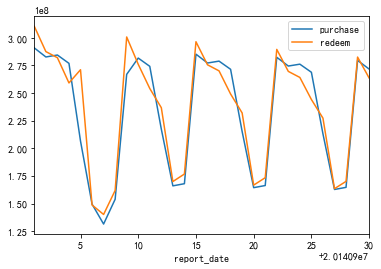

In [93]:
final_data_pd = final_data_pd.set_index(['report_date'])

#final_data_pd.to_csv("./tc_comp_predict_table1.csv")

final_data_pd.plot()

In [94]:
final_data_pd.to_csv("./tc_comp_predict_table1.csv")